## Test copy

In [15]:
# Utils
def func_time(title="DEFAULT"):
    def decorator(func):
        def wrapper(*args, **kwargs):
            tic = time.perf_counter()
            res = func(*args, **kwargs)
            toc = time.perf_counter()
            print(f"[{title}] Time: {toc - tic} s")
            return res
        return wrapper
    return decorator

In [ ]:
@func_time("Sequential")
def sequential_computation(stencil, field):
    pass

[Text(0.5, 0, '# streams'), Text(0, 0.5, 'Time [s]')]

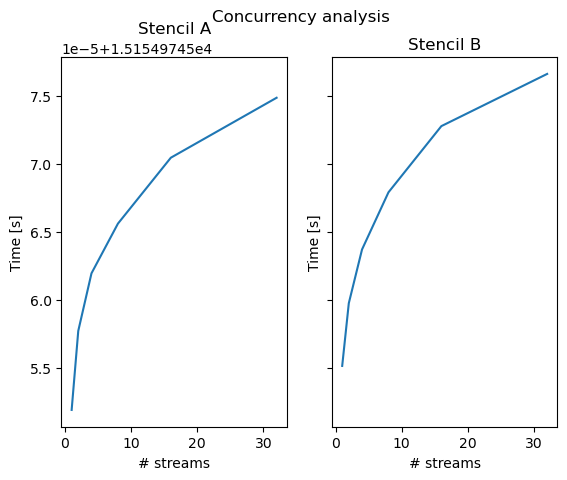

In [18]:
# Plots
fig, (axA, axB) = plt.subplots(1, 2, sharey=True)
fig.suptitle("Concurrency analysis")

axA.plot(steps_concurrency, times_a_concur)
axA.set_title("Stencil A")
axA.set(xlabel='# streams', ylabel='Time [s]')

axB.plot(steps_concurrency, times_b_concur)
axB.set_title("Stencil B")
axB.set(xlabel='# streams', ylabel='Time [s]')


In [2]:
a = 2+3
a

5

In [ ]:

def update_halo(field, num_halo):
    """ Update the halo-zone using an up/down and left/right strategy.

    Parameters
    ----------
    field : array-like
        Input/output field (nz x ny x nx with halo in x- and y-direction).
    num_halo : int
        Number of halo points.
    
    Note
    ----
        Corners are updated in the left/right phase of the halo-update.
    """
    # bottom edge (without corners)
    field[:, :num_halo, num_halo:-num_halo] = field[
        :, -2 * num_halo : -num_halo, num_halo:-num_halo
    ]

    # top edge (without corners)
    field[:, -num_halo:, num_halo:-num_halo] = field[
        :, num_halo : 2 * num_halo, num_halo:-num_halo
    ]

    # left edge (including corners)
    field[:, :, :num_halo] = field[:, :, -2 * num_halo : -num_halo]

    # right edge (including corners)
    field[:, :, -num_halo:] = field[:, :, num_halo : 2 * num_halo]


In [ ]:
def compute_gpu(input_field, stencil, n_stream, n_iter, n_halo):
    # Init
    output_field = input_field
    
    # Create streams
    streams = [ cp.cuda.Stream() for _ in range(n_stream) ]

    for _ in range(n_iter):
        e = cp.cuda.Event()
        e.record()
        update_halo(input_field, n_halo)

        for s in streams:
            with s:
                stencil(input_field, output_field)
        e.syncronize()
    return output_field

In [ ]:


def apply_diffusion(in_field, out_field, alpha, num_halo, num_iter=1):
    """ Integrate 4th-order diffusion equation by a certain number of iterations.

    Parameters
    ----------
    in_field : array-like
        Input field (nz x ny x nx with halo in x- and y-direction).
    lap_field : array-like
        Result (must be same size as ``in_field``).
    alpha : float
        Diffusion coefficient (dimensionless).
    num_iter : `int`, optional
        Number of iterations to execute.
    """
    tmp_field = np.empty_like(in_field)

    for n in range(num_iter):
        update_halo(in_field, num_halo)

        laplacian(in_field, tmp_field, num_halo=num_halo, extend=1)
        laplacian(tmp_field, out_field, num_halo=num_halo, extend=0)

        out_field[:, num_halo:-num_halo, num_halo:-num_halo] = (
            in_field[:, num_halo:-num_halo, num_halo:-num_halo]
            - alpha * out_field[:, num_halo:-num_halo, num_halo:-num_halo]
        )

        if n < num_iter - 1:
            in_field, out_field = out_field, in_field
        else:
            update_halo(out_field, num_halo)


@click.command()
@click.option(
    "--nx", type=int, required=True, help="Number of gridpoints in x-direction"
)
@click.option(
    "--ny", type=int, required=True, help="Number of gridpoints in y-direction"
)
@click.option(
    "--nz", type=int, required=True, help="Number of gridpoints in z-direction"
)
@click.option("--num_iter", type=int, required=True, help="Number of iterations")
@click.option(
    "--num_halo",
    type=int,
    default=2,
    help="Number of halo-pointers in x- and y-direction",
)
@click.option(
    "--plot_result", type=bool, default=False, help="Make a plot of the result?"
)
def main(nx, ny, nz, num_iter, num_halo=2, plot_result=False):
    """Driver for apply_diffusion that sets up fields and does timings"""

    assert 0 < nx <= 1024 * 1024, "You have to specify a reasonable value for nx"
    assert 0 < ny <= 1024 * 1024, "You have to specify a reasonable value for ny"
    assert 0 < nz <= 1024, "You have to specify a reasonable value for nz"
    assert (
        0 < num_iter <= 1024 * 1024
    ), "You have to specify a reasonable value for num_iter"
    assert (
        2 <= num_halo <= 256
    ), "Your have to specify a reasonable number of halo points"
    alpha = 1.0 / 32.0

    in_field = np.zeros((nz, ny + 2 * num_halo, nx + 2 * num_halo))
    in_field[
        nz // 4 : 3 * nz // 4,
        num_halo + ny // 4 : num_halo + 3 * ny // 4,
        num_halo + nx // 4 : num_halo + 3 * nx // 4,
    ] = 1.0

    out_field = np.copy(in_field)

    np.save("in_field", in_field)

    if plot_result:
        plt.ioff()
        plt.imshow(in_field[in_field.shape[0] // 2, :, :], origin="lower")
        plt.colorbar()
        plt.savefig("in_field.png")
        plt.close()

    # warmup caches
    apply_diffusion(in_field, out_field, alpha, num_halo)

    # time the actual work
    tic = time.time()
    apply_diffusion(in_field, out_field, alpha, num_halo, num_iter=num_iter)
    toc = time.time()

    print(f"Elapsed time for work = {toc - tic} s")

    np.save("out_field", out_field)

    if plot_result:
        plt.imshow(out_field[out_field.shape[0] // 2, :, :], origin="lower")
        plt.colorbar()
        plt.savefig("out_field.png")
        plt.close()


if __name__ == "__main__":
    main()
